In [1]:

import os
import skimage

import numpy as np

from scipy.misc import imread, imresize
from skimage import color
from utils import gauss2d


class InputProducer:
	def __init__(self, imgs_path, gt_path, live=False):
		"""
		Class for handle input images. 
		
		Args:
			imgs_path: String, directory for specifying the path of images.
			gt_path: String, filename of groundtruth file, which contains target 
				bounding box info in each line.
			live: bool, indicator for live video # TODO, implement.
	
		"""
		self.imgs_path_list = [os.path.join(imgs_path, fn) for fn in sorted(os.listdir(imgs_path))]
		self.gts_list = self._gen_gts(gt_path)
		self.gen_img = self.get_image()

		self.roi_params = {
		'roi_size': 224, 
		'roi_scale': 3,
		'l_off': [0,0]
		}

	def get_image(self):
		"""Generator for retrieve images and groundtruth bbox.
		Yields:
			img: np.ndarray with shape [240, 320, 3]
			gt: list, specifying location of interested target.
				[tlx, tly, w, h]
			idx: int, index of current image.
		"""
		idx = -1
		for img_path, gt in zip(self.imgs_path_list, self.gts_list):
			img = imread(img_path, mode='RGB')

			assert min(img.shape[:2]) >= 28

			# Gray to color. RES??
			#if len(img.shape) < 3:
			#img = skimage.color.gray2rgb(img)
			assert len(img.shape) == 3

			idx += 1
			if idx == 0: 
				self.first_gt = gt
				self.first_img = img
			yield img, gt, idx


	def _gen_gts(self, gt_path):
		"""
		Parse location info from ground truth file.
		Each row in the ground-truth files represents the bounding box 
		of the target in that frame. (tl_x, tl_y, box-width, box-height)
		
		Args:
			gt_path: string.
		Returns:
			gts_list: a nested list.
		"""
		f = open(gt_path, 'r')
		lines = f.readlines()

		try:
			gts_list = [[int(p) for p in i[:-1].split(',')] 
			                   for i in lines]
		except Exception as e:
			gts_list = [[int(p) for p in i[:-1].split('\t')] 
			                   for i in lines]
		return gts_list

	def extract_roi(self, img, gt):
		"""Extract ROI from img with target region centered.

		Args:
			img: np.ndarray, origin image.
			gt: list, locations for top-left x, top-left y, width, height.
		Returns:
		    roi: tensor,
		    roi_pos: list of params for roi_pos, [tlx, tly, w, h].
			resize_factor: float, translational scalling factor from 
				original image space to roi space. 
				>1 for enlarger, <1 for ensmaller.
		"""
		roi_size  = self.roi_params['roi_size']
		#assert max(gt[2:]) <= roi_size

		# Construct an padded img first.
		convas = np.zeros([img.shape[0]+2*roi_size, img.shape[1]+2*roi_size, 3])
		convas[roi_size:-roi_size, roi_size:-roi_size] = img

		# Compute target center location in convas
		tlx_convas, tly_convas = gt[0]+roi_size, gt[1]+roi_size
		cx = tlx_convas + int(0.5 * gt[2])
		cy = tly_convas + int(0.5 * gt[3])

		# Crop an roi_size region centered at cx, cy
		scale_sz = max(gt[2:]) * self.roi_params['roi_scale']
		half = scale_sz // 2
		roi = convas[cy-half:cy+half, cx-half:cx+half, :]

		# compute new target pos in roi window
		new_cx, new_cy = [int(i*0.5) for i in roi.shape[:-1]]
		new_x = new_cx - gt[2] // 2
		new_y = new_cx - gt[3] // 2
	    
		roi_resized = imresize(roi, (roi_size, roi_size))
		resize_factor = roi_size / roi.shape[0]
		return roi_resized, [new_x, new_y, gt[2], gt[3]], resize_factor


	def gen_mask(self, fea_sz=(28,28), im_sz=None, gt=None):
		"""
		Generates a 2D guassian masked convas with shape same as 
		fea_sz. This method should only called on the first frame.

		Args:
			fea_sz: 2 elements tuple, to be identical with the 
				Output of sel-CNN net.
		Returns:
			convas: np.ndarray, fea_sz shape with 1 channel. The central 
				region is an 2D gaussian.
		"""
		if im_sz is None: im_sz = self.first_img.shape
		if gt is None:
			x, y, w, h = self.first_gt
		else: 
			x, y, w, h = gt
			self.first_gt = gt
		convas = np.zeros(im_sz[:2])

		# Generates 2D gaussian mask
		scale = min([w,h]) / 3 # To be consistence with the paper
		mask = gauss2d([h, w], sigma=scale)
		#print(mask.max(), 'max of mask')

		# bottom right coordinate
		x2 = x + w - 1
		y2 = y + h - 1

		# Detects wether the location has out of the img or not
		clip = min(x, y, im_sz[0]-y2, im_sz[1]-x2)
		pad = 0
		if clip <= 0:
			pad = abs(clip) + 1
			convas = np.zeros((im_sz[0] + 2*pad, im_sz[1] + 2*pad))
			x += pad
			y += pad
			x2 += pad
			y2 += pad

		# Overwrite central arear of convas with mask;
		convas[y-1:y2, x-1:x2] = mask
		if clip <= 0:
			# Remove pad
			convas = convas[pad:-pad, pad, -pad]

		if len(convas.shape) < 3:
			convas = color.gray2rgb(convas)
		assert len(convas.shape) == 3

		# Extrac ROI and resize bicubicly
		convas, _, _  = self.extract_roi(convas, self.first_gt)
		#print(convas.shape)
		convas = imresize(convas[...,0], fea_sz[:2], interp='bicubic')

		# Swap back, and normalize
		convas = convas / convas.max()

		return convas

	def gen_batches(self, img, gt, n_samples=5000, batch_sz=10, pos_ratio=0.7, scale_factors=None):
		""" 
		Returns batched trainning examples, with which's target location and 
		width/height ratio are randomly distored.
		
		Args:
			img: np.ndarry with shape (240, 320, 3)
			gt: list, [tlx, tly, w, h] location for target.
			n_samples: int, total number of samples would like to generate.
			batch_sz: int, number of examples in a batch. 
			pos_ratio: float, in range (0, 1], portion of postitive samples
				in total samples.
			scale_factors: list, specifying scale factors when extracting target
				from image in the process of generating random postive samples. 
		Returns:
			sample_batches: list of roi batches. with each roi batch has shape
				[batch_size, 28, 28, 3].
			target_batches: list of target batches. with each target batch jas shape
				[batch_size, 28, 28, 3].
		"""

		# Gen n_pos number of scaled samples 
		n_pos = int(n_samples/pos_ratio)
		if scale_factors is None: scale_factors = np.arange(0.2, 5., 0.5)
		samples = []
		targets = []
		for pos_idx in range(n_pos):
			sf_idx = pos_idx % len(scale_factors)
			self.roi_params['roi_scale'] = scale_factors[sf_idx]
			roi, _, _ = self.extract_roi(img, gt)
			gt_M = self.gen_mask((28,28)).astype(np.float32)
			samples += [roi]
			targets += [gt_M]

		# Gen negative samples with random scale factor
		gt_M_neg = np.zeros((28,28), dtype=np.float32)
		for _ in range(n_samples - n_pos):
			lb, up = scale_factors[0], scale_factors[-1]
			self.roi_params['roi_scale'] = np.random.uniform(lb, up)
			roi = self._gen_neg_samples(img, gt)
			samples += [roi]
			targets += [gt_M_neg]

		# Random shuffeling 
		rand_idx = np.random.permutation(len(samples))
		samples = np.array(samples)[rand_idx]
		targets = np.array(targets)[rand_idx]

		# Batching
		sample_batches = [samples[i:i+batch_sz] for i in range(len(samples)) if i % batch_sz==0]
		target_batches = [targets[i:i+batch_sz] for i in range(len(targets)) if i % batch_sz==0]
		return sample_batches, target_batches

	def _gen_neg_samples(self, img, gt_1):
		"""
		Private method for generating negative samples,
		i.e., randomly extract a non-target region from image.

		Args:
			img: np.ndarray. 3D array
			gt_1: list, groundtruth for the target to avoid.
		Returns:
			roi_rand: np.ndarry, same shape as img. genrated negative sample.
		"""

		delta = 30 
		img = img.copy()
		w, h = gt_1[2:]
		tl_x, tl_y = gt_1[:2]
		tr_x, tr_y = tl_x + w, tl_y 
		dl_x, dl_y = tl_x, tl_y + h
		dr_x, dr_y = tl_x + w, tl_y +h
		img[tl_y:dr_y+delta,tl_x:dr_x+delta] = img.mean()
		
		# randomly extract an arear specified by gt_1
		x = np.random.randint(0, 28-w)
		y = np.random.randint(0, 28-h)
		roi_rand,_,_ = self.extract_roi(img, [y,x, w,h])
		return roi_rand







In [2]:
"""
Main script for FCNT tracker. 
"""

# Import custom class and functions
#from inputproducer import InputProducer
from tracker import TrackerVanilla
from vgg16 import Vgg16
from sgnet import GNet, SNet
from utils import img_with_bbox, IOU_eval, select_fms

import numpy as np 
import tensorflow as tf
import matplotlib.pylab as plt

from scipy.misc import imresize
from subprocess import call
import sys
import os
import time

tf.app.flags.DEFINE_integer('iter_epoch_sg', 5,
                          """Number of epoches for trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('batch_size', 35,
                          """Batch size for SGNet trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('n_samples_per_batch', 5000,
                          """Number of samples per batch for trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('iter_max', 1349,
							"""Max iter times through imgs""")
tf.app.flags.DEFINE_integer('sel_num', 354,
                          """Number of feature maps selected.""")
tf.app.flags.DEFINE_string('model_name', 'SelfMade1',
						"""true for train, false for eval""")
FLAGS = tf.app.flags.FLAGS

## Define varies pathes
DATA_ROOT = 'data/Car1'
PRE_ROOT = os.path.join(DATA_ROOT, 'img_loc')
IMG_PATH = os.path.join(DATA_ROOT, 'img')
GT_PATH = os.path.join(DATA_ROOT, 'groundtruth_rect.txt')
VGG_WEIGHTS_PATH = 'vgg16_weights.npz'

if not os.path.isdir(PRE_ROOT):
    os.mkdir(PRE_ROOT)


TB_SUMMARY = os.path.join('tb_summary', FLAGS.model_name)
if not os.path.isdir('tb_summary'):
    os.mkdir('tb_summary')
if not os.path.isdir(TB_SUMMARY):
    os.mkdir(TB_SUMMARY)

CKPT_PATH = 'checkpoint'
if not os.path.isdir(CKPT_PATH):
    os.mkdir(CKPT_PATH)

model_name = FLAGS.model_name+'.ckpt'
CKPT_MODEL = os.path.join(CKPT_PATH, model_name)

def init_vgg(roi_t0):
    """
    Initialize a tf.Session and a vgg16 graph. Followed
    by forwarding the vgg net once to predict top5 class labels
    for image generated in the first frame.

    Args:
        roi_t0: np.ndarray with shape (28x28x3), extracted roi in the first frame.
    Returns:
        sess: tf.Session object.
        vgg: Vgg16 class instance.
    """
    print('Classify it with a pre-trained Vgg16 model.')
    t_start = time.time()
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    vgg = Vgg16(VGG_WEIGHTS_PATH, sess)
    vgg.print_prob(roi_t0, sess)
    print('Forwarding the vgg net cost : %.2f s'%(time.time() - t_start))
    return sess, vgg

def gen_sel_maps(sess, roi, vgg, idx_c4, idx_c5):
    """Returns selected c4 and c5 maps"""
    if len(roi.shape) == 3: roi = [roi]
    fd = {vgg.imgs : roi}
    c4_arr, c5_arr = sess.run([vgg.conv4_3_norm, vgg.conv5_3_norm], feed_dict=fd)
    c4_maps = c4_arr[...,idx_c4]
    c5_maps = c5_arr[...,idx_c5]
    return c4_maps, c5_maps


def train_SGNets(sess, img, gt, vgg, snet, gnet, inputProducer, idx_c4, idx_c5):
    """
    Train SGnets' variables by minimizing a composite L2 regression losses.

    Args:
        sess: tf.Session object.
        vgg: Vgg16 class instance.
        snet: SNet class instance.
        gnet:  GNet class instance.
        inputProducer: InputProducer class instance.
    """
    gnet.params['wd'] = 0.5
    gloss, sloss = gnet.loss(), snet.loss()
    loss = gloss  + sloss
    tf.scalar_summary('loss', loss)
    writer = tf.train.SummaryWriter(TB_SUMMARY, sess.graph)
    
    vars_train = gnet.variables + snet.variables

    # Backprop using SGD and updates vgg variables and sgnets variables
    global_step = tf.Variable(0, trainable=False)
    lr_exp = tf.train.exponential_decay(
            0.25, # Initial learning rate 
            global_step, 
            1000, # Decay steps 
            0.8, # Decay rate 
            name='sg_lr')

    tf.scalar_summary('Learning rate', lr_exp)
    optimizer = tf.train.GradientDescentOptimizer(lr_exp)
    train_op = optimizer.minimize(loss, var_list= vars_train, global_step=global_step)
    merged = tf.merge_all_summaries()

    sample_batches, target_batches = inputProducer.gen_batches(img, gt, n_samples=FLAGS.n_samples_per_batch, batch_sz=FLAGS.batch_size, pos_ratio=0.5, scale_factors=np.arange(0.5, 5., 0.2)) #np.array([1]))#
    print('Start training the SGNets........ for %s epoches'%FLAGS.iter_epoch_sg)
    saver = tf.train.Saver()
    step = 1
    loss_list = []
    for ep in range(FLAGS.iter_epoch_sg):
        print('Total batches in each epoch: ', len(sample_batches))
        for roi, target in zip(sample_batches, target_batches):
            #roi[roi>0] = 1 # neglect gaussian..set to 1 for target arear
            
            t = time.time()
            c4_maps, c5_maps = gen_sel_maps(sess, roi, vgg, idx_c4, idx_c5)
            
            fd = {gnet.input_maps: c5_maps, gnet.gt_M: target, 
                  snet.input_maps: c4_maps, snet.gt_M: target}
            
            # Initialization 
            if step == 1:
                loss_g = 10
                init_s = 0
                while loss_g > 1.5:
                    init_s += 1
                    sess.run(tf.initialize_variables(gnet.variables))
                    loss_g = sess.run(gloss, feed_dict=fd)
                    print('Initial Gnet Loss: ', loss_g, 'In steps: ', init_s)
                sess.run(tf.initialize_variables(snet.variables + [global_step]))
                
            
            pre_M_g, l, _, lr = sess.run([gnet.pre_M, loss, train_op, lr_exp], feed_dict=fd)
            
            loss_list += [l]
            if l <= 0.1:
                print('break learning!')
                break
            if step % 20 == 0:
                
                loss_ac = np.diff(np.diff(loss_list[-19:]))
                loss_ac_summary = tf.scalar_summary('Loss acceleration', loss_ac.mean())
                
                
                summary_img_g = tf.image_summary('pre_M', 
                                                 np.repeat(pre_M_g[...,np.newaxis], 3, axis=-1), name='GMap')

                summary, img_summary_g, ac_loss_summary = sess.run([merged, summary_img_g, loss_ac_summary], feed_dict=fd)

                writer.add_summary(summary, global_step=step)
                writer.add_summary(img_summary_g, global_step=step)
                writer.add_summary(ac_loss_summary, global_step=step)
                
                loss_std = np.std(loss_list[-19:])
                if loss_std <= 0.007:
                    
                    print('Stop learning! Last 10 batches Loss Std: ', loss_std)
                    break

            #if step % 20 == 0:
                print('Epoch: ', ep+1, 'Step: ', (ep+1)*step, 'Loss : %.2f'%l, \
                    'Speed: %.2f second/batch'%(time.time()-t), 'Lr: ', lr)
                #saver.save(sess, CKPT_MODEL)
            step += 1



print('Reading the first image...')
t_start = time.time()
## Instantiate inputProducer and retrive the first img
# with associated ground truth. 
inputProducer = InputProducer(IMG_PATH, GT_PATH)
#img, gt, s  = next(inputProducer.gen_img)





Reading the first image...


In [3]:
import cv2
import skimage.io
import skimage.transform

show = skimage.io.imshow
%matplotlib inline

vid_path = 'data/selfmade1/DJI_0029.MOV'
vidcap = cv2.VideoCapture(vid_path)

ret, img = vidcap.read()

#cv2.imshow('original image', img)





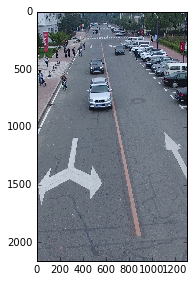

In [4]:
img = img[ :, 1200:2500, [2,1,0]]
img1 = imresize(img, (int(300*s), 300))


gt = [95, 127, 61, 79] #[640, 550, 200, 300]
x,y,w,h = gt
img2 = cv2.rectangle(img1.copy(), (x, y), (x+w, y+h), (255,0,0), 4)
show(img2)

In [8]:
img = img1

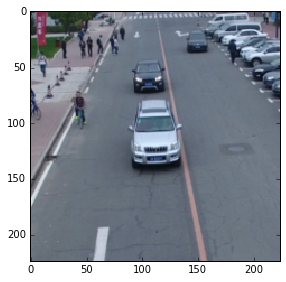

In [9]:

inputProducer.roi_params['roi_scale'] = 3
roi_t0, _, rz_factor = inputProducer.extract_roi(img, gt)
show(roi_t0)
plt.show()


In [10]:

sess = tf.Session()
#sess.run(tf.initialize_all_variables())
vgg = Vgg16(VGG_WEIGHTS_PATH, sess)
#vgg.print_prob(roi_t0, sess)

In [11]:
vgg.print_prob(roi_t0, sess)

aircraft carrier, carrier, flattop, attack aircraft carrier 0.113888
cab, hack, taxi, taxicab 0.0940312
streetcar, tram, tramcar, trolley, trolley car 0.0633319
traffic light, traffic signal, stoplight 0.0407882
limousine, limo 0.0329798


In [12]:
#sess, vgg = init_vgg(roi_t0)
fd = {vgg.imgs: [roi_t0]}
InputProducer.first_img = img
InputProducer.first_gt = gt
gt_M = inputProducer.gen_mask((28,28)) # rank2 array

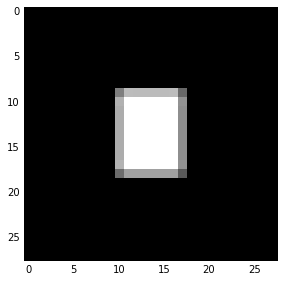

In [13]:
show(gt_M)

In [14]:



## At t=0. Train S and G Nets 
# Instainate SGNets with conv tensors and training.
# 1. feature maps selection
# 2. Train G and S networks.
idx_c4 = select_fms(sess, vgg.conv4_3_norm, gt, rz_factor, fd, FLAGS.sel_num)
idx_c5 = select_fms(sess, vgg.conv5_3_norm, gt, rz_factor, fd, FLAGS.sel_num)
snet = SNet('SNet', FLAGS.sel_num)
gnet = GNet('GNet', FLAGS.sel_num)
train_SGNets(sess, img, gt, vgg, snet, gnet, inputProducer, idx_c4, idx_c5)

/home/xlws/repos/FCNT_bak/utils.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  conf_i = roi[c-h_half:c+h_half, c-w_half:c+w_half].sum()
/home/xlws/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Start training the SGNets........ for 5 epoches
Total batches in each epoch:  286
Initial Gnet Loss:  4.90116 In steps:  1
Initial Gnet Loss:  3.36194 In steps:  2
Initial Gnet Loss:  4.87167 In steps:  3
Initial Gnet Loss:  2.04542 In steps:  4
Initial Gnet Loss:  3.09985 In steps:  5
Initial Gnet Loss:  2.17201 In steps:  6
Initial Gnet Loss:  1.92512 In steps:  7
Initial Gnet Loss:  1.72295 In steps:  8
Initial Gnet Loss:  1.6269 In steps:  9
Initial Gnet Loss:  2.13767 In steps:  10
Initial Gnet Loss:  1.38109 In steps:  11
Epoch:  1 Step:  20 Loss : 1.54 Speed: 0.94 second/batch Lr:  0.248942
Epoch:  1 Step:  40 Loss : 1.51 Speed: 0.80 second/batch Lr:  0.247834
Epoch:  1 Step:  60 Loss : 1.49 Speed: 0.86 second/batch Lr:  0.24673
Epoch:  1 Step:  80 Loss : 1.21 Speed: 0.86 second/batch Lr:  0.245632
Epoch:  1 Step:  100 Loss : 1.23 Speed: 0.93 second/batch Lr:  0.244538
Epoch:  1 Step:  120 Loss : 1.18 Speed: 0.84 second/batch Lr:  0.243449
Epoch:  1 Step:  140 Loss : 1.16 Speed:

In [15]:
## Instainate a tracker object, set apoproaite initial parameters.
tracker = TrackerVanilla(gt)
inputProducer.roi_params['roi_scale'] = 3
norm_roi_scale_w = inputProducer.roi_params['roi_scale'] / gt[2]
tracker.params['aff_sig'] = [10, 10, 0.6, 0.6]
tracker.params['p_num'] = 800
tracker.params['particle_scales'] = [1,1]


# Iter imgs

gt_last = gt 
gt_list = []
pre_M_list = []
roi_list = []
res_list = []
diff_list = []

ret = True
i = 0

i am new!


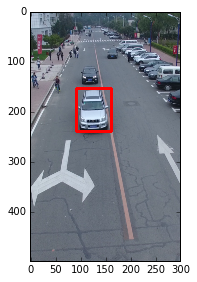

29
0.0


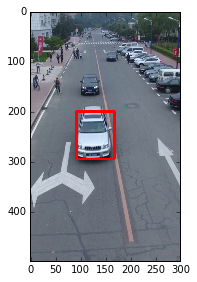

59
0.0666666666667


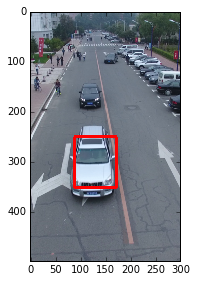

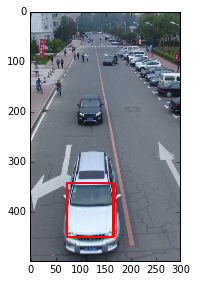

89
0.0
At frame 100, the most confident value is 1.0982678394275112
Time consumed : 0.07 s


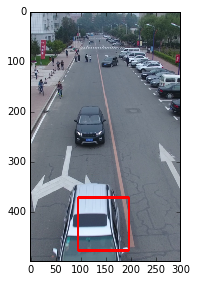

119
0.0333333333333


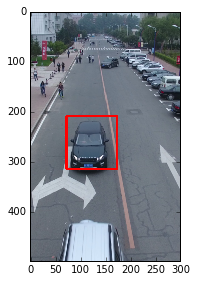

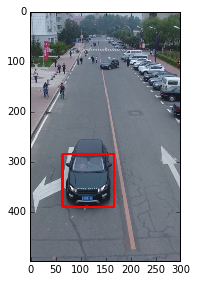

149
0.0333333333333


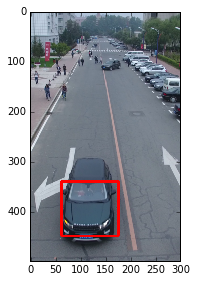

179
-0.0666666666667


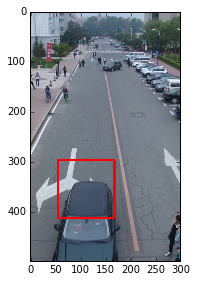

At frame 200, the most confident value is 1.18845773666202
Time consumed : 0.07 s


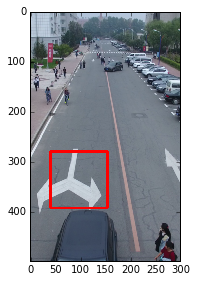

209
0.0333333333333


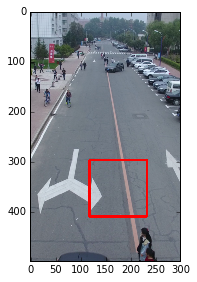

TypeError: 'NoneType' object is not subscriptable

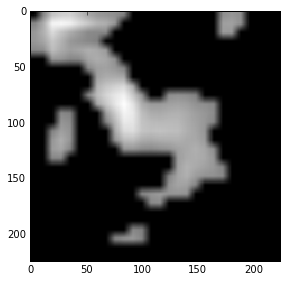

In [20]:

while ret:
    ret, img = vidcap.read()
    img = img[ :, 1200:2500, [2,1,0]]
    img = imresize(img, (int(300*s), 300))
    i += 1
    if i % 30 == 0:
        print(len(gt_list))
        v = np.diff([loc[2] for loc in gt_list[-30:]])
        ac = np.diff(v)
        acv = ac[-30:].sum() / 30
        print(acv)
        if acv >= 0.8:
            tracker.params['particle_scales'] = particle_scale*np.array([1.1, 1.2, 1.3, 1.4]) 
        elif acv < -0.8:
            tracker.params['particle_scales'] = particle_scale*np.array([0.9, 0.8, 0.7, 0.6])


    t_enter = time.time()

    

    ## Crop a rectangle ROI region centered at last target location.
    roi, _, rz_factor = inputProducer.extract_roi(img, gt_last)
    
    roi[roi==0] = roi.mean()

    ## Perform Target localiation predicted by GNet
    # Get heat map predicted by GNet
    c4_maps, c5_maps = gen_sel_maps(sess, roi, vgg, idx_c4, idx_c5)
    fd = {gnet.input_maps: c5_maps, snet.input_maps: c4_maps}

    pre_M_g, pre_M_s = sess.run([gnet.pre_M, snet.pre_M], feed_dict=fd)
    pre_M_list += [(pre_M_g, pre_M_s)]
    
    pre_M_g[pre_M_g<=0.5] = 0
    pre_M_g = imresize(pre_M_g, (224,224))
    
    roi_list += [roi]
    # Localize target with monte carlo sampling.
    pre_loc = tracker.predict_location(pre_M_g, gt_last, rz_factor, img)

    if i % 100 == 0:
        print('At frame {0}, the most confident value is {1}'.format(i, tracker.cur_best_conf))
        print('Time consumed : %.2f s'%(time.time() - t_enter))

    gt_last = pre_loc
    gt_list += [pre_loc]
    

    # Draw bbox on image. And print associated IoU score.
    x,y,w,h = pre_loc
    img_bbox = cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 4)
    #file_name = FLAGS.model_name + inputProducer.imgs_path_list[i-1].split('/')[-1]
    file_name = os.path.join('data/selfmade1', '%s.jpg'%i) 
    plt.imsave(file_name, img_bbox)
    
    res_list += [img_bbox]
    if i % 20 ==0:
        show(img_bbox)
        plt.show()
        show(pre_M_g)


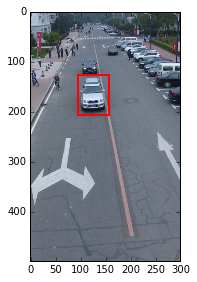

In [19]:
show(img_bbox)

In [21]:

vid_path_prefix = 'data/selfmade1/' 
os.system('ffmpeg -framerate 25 -i %s%%d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p %s.mp4'\
          %(vid_path_prefix, FLAGS.model_name))

0

In [ ]:
k=410
show(res_list[k])
plt.show()
show(roi_list[k])
plt.show()
show(pre_M_list[k][0])
plt.show()
show(pre_M_list[k][1])

In [ ]:
vid_path_prefix = os.path.join(PRE_ROOT, FLAGS.model_name) 
os.system('ffmpeg -framerate 25 -i %s%%04d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p %s.mp4'\
          %(vid_path_prefix, FLAGS.model_name))

In [ ]:
len(inputProducer.imgs_path_list)

In [ ]:
for k,prem in enumerate(pre_M_list):
    if k % 20 ==0:
        show(prem)
        plt.show()
        show(roi_list[k])
        plt.show()

In [ ]:

t_enter = time.time()
# Gnerates next frame infos
img, gt_cur, s  = next(inputProducer.gen_img)

## Crop a rectangle ROI region centered at last target location.
roi, _, rz_factor = inputProducer.extract_roi(img, gt_last)

## Perform Target localiation predicted by GNet
# Get heat map predicted by GNet
c4_maps, c5_maps = gen_sel_maps(sess, roi, vgg, idx_c4, idx_c5)
fd = {gnet.input_maps: c5_maps, snet.input_maps: c4_maps}

pre_M_g, _ = sess.run([gnet.pre_M, snet.pre_M], feed_dict=fd)

#pre_M_g = imresize(pre_M_g, (224,224))

In [ ]:
os.system('ffmpeg -framerate 25 -i %s%%04d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p %sTEST.mp4'%(vid_path_prefix, FLAGS.model_name))

In [ ]:
call(['ffmpeg', '-framerate 25 -i %s%%04d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p %sTEST.mp4'%(vid_path_prefix, FLAGS.model_name)])

In [ ]:
show(pre_M_g)

In [ ]:
pre_M_g =  imresize(pre_M_g, (224,224))
# Localize target with monte carlo sampling.
pre_loc = tracker.predict_location(pre_M_g, gt_last, rz_factor, img)

gt_last = pre_loc
gt_list += [pre_loc]
print('pre: ', pre_loc, 'actual: ', gt_cur)

# Draw bbox on image. And print associated IoU score.
img_bbox = img_with_bbox(img, pre_loc,c=1)
show(img_bbox)

In [ ]:
show(img_bbox)

In [ ]:
pre_M_g_1 = pre_M_g.copy()

In [ ]:
pre_M_g_1[pre_M_g_1<0.5] = 0
show(pre_M_g_1)

In [ ]:
np.argmax(pre_M_g_1, axis=0)